In [1]:
import os
import csv

import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, mean_squared_error

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import RepeatVector, TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Lambda, Input, Dense, LSTM
from tensorflow.keras.losses import MeanSquaredLogarithmicError, mse, binary_crossentropy, kl_divergence

tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

print("Setup Complete")

ModuleNotFoundError: No module named 'pandas'

In [2]:
!pip install pandas
!pip install tensorflow

  Using cached pytz-2022.1-py2.py3-none-any.whl (503 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached absl_py-1.1.0-py3-none-any.whl (123 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)


ERROR: Exception:
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\a2\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\ProgramData\Anaconda3\envs\a2\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\ProgramData\Anaconda3\envs\a2\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\ProgramData\Anaconda3\envs\a2\lib\http\client.py", line 465, in read
    n = self.readinto(b)
  File "C:\ProgramData\Anaconda3\envs\a2\lib\http\client.py", line 509, in readinto
    n = self.fp.readinto(b)
  File "C:\ProgramData\Anaconda3\envs\a2\lib\socket.py", line 589, in readinto
    return self._sock.recv_into(b)
  File "C:\ProgramData\Anaconda3\envs\a2\lib\ssl.py", line 1071, in recv_into
    return self.read(nbytes, buffer)
  File "C:\ProgramData\Anaconda3\envs\a2\lib\ssl.py", 

Feature Extraction and Extension CODE: https://github.com/min0355/ai-novatus/blob/main/PBL%20main%20code/No.3_Feature%20selection%20and%20Feature%20Extension.ipynb

In [2]:
def make_df(df, label):
    
    for col in label:
        print(col)
        le = LabelEncoder()
        k = df.pop(col)
        le.fit(k)
        k = pd.DataFrame(le.transform(k))
        df = pd.concat([df, k], axis=1)
        
    return df

In [3]:
df = pd.read_csv(r'/home/kym/ML/input/ai_nova/pre_sensor.csv')

feature = [
    f for f in df.columns if f in ("timestamp", "sensor_04", "operation")
]

df = df[feature]
df = make_df(df, ['operation'])

df.to_csv(r'/home/kym/ML/input/ai_nova/final_sensor.csv', index=False)
df.head()

operation


,timestamp,sensor_04,0
0,2018-04-01 00:00:00,0.792242,0
1,2018-04-01 00:01:00,0.792242,0
2,2018-04-01 00:02:00,0.797904,0
3,2018-04-01 00:03:00,0.784402,0
4,2018-04-01 00:04:00,0.794855,0


In [4]:
def load_data(dataset, csv_folder='/home/kym/ML/input/ai_nova/'):
    if dataset == 'final_sensor':
        data_file = os.path.join(csv_folder, 'final_sensor.csv') # only remain timestamp, sensor_04, (label)
        anomalies = ['2018-04-12 21:55:00', '2018-04-18 00:30:00', '2018-05-19 03:18:00', '2018-05-25 00:30:00', 
                     '2018-06-28 22:00:00', '2018-07-08 00:11:00', '2018-07-25 14:00:00']
        t_unit = '1 min'
    
    t = []
    readings = []
    idx_anomaly = []
    
    i = 0
    
    with open(data_file) as csvfile:
        readCSV = csv.reader(csvfile)
        print("\n --> Anomalies occur at: ")
        
        for row in readCSV:
            if i > 0:
                t.append(i)
                readings.append(float(row[1]))
                for j in range(len(anomalies)):
                    if row[0] == anomalies[j]:
                        idx_anomaly.append(i)
                        print("   timestamp #{}: {}".format(j, row[0]))
            i += 1
    
    t = np.asarray(t)
    readings = np.asarray(readings)
    print("\nOriginal CSV file contains {} timestamps.".format(t.shape))
    print("Processed time series contain {} reading.".format(readings.shape))
    print("Anomaly indices are {}".format(idx_anomaly))
    
    return t, t_unit, readings, idx_anomaly

In [5]:
load_data('final_sensor')


 --> Anomalies occur at: 
   timestamp #0: 2018-04-12 21:55:00
   timestamp #1: 2018-04-18 00:30:00
   timestamp #2: 2018-05-19 03:18:00
   timestamp #3: 2018-05-25 00:30:00
   timestamp #4: 2018-06-28 22:00:00
   timestamp #5: 2018-07-08 00:11:00
   timestamp #6: 2018-07-25 14:00:00

Original CSV file contains (220320,) timestamps.
Processed time series contain (220320,) reading.
Anomaly indices are [17156, 24511, 69319, 77791, 128041, 141132, 166441]


(array([     1,      2,      3, ..., 220318, 220319, 220320]),
 '1 min',
 array([0.79224211, 0.79224211, 0.79790429, ..., 0.78164367, 0.79383907,
        0.79906572]),
 [17156, 24511, 69319, 77791, 128041, 141132, 166441])

In [6]:
def process_and_save_specified_dataset(dataset, idx_split, y_scale=5, save_file=False):
    t, t_unit, readings, idx_anomaly = load_data(dataset)
    
    # split train and test sets
    training = readings[idx_split[0]:idx_split[1]]
    t_train = t[idx_split[0]:idx_split[1]]
    
    # for general algorithm (Normalization)
    train_m = np.mean(training)
    train_std = np.std(training)
    print("\nTraining set mean is {}".format(train_m))
    print("Training set std id {}".format(train_std))
    readings_normalised = (readings - train_m) / train_std
    training = readings_normalised[idx_split[0]:idx_split[1]]
    
    if idx_split[0] == 0:
        test = readings_normalised[idx_split[1]]
        t_test = t[idx_split[1]:] - idx_split[1]
        idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]
    else:
        test = [readings_normalised[:idx_split[0]], readings_normalised[idx_split[1]:]]
        t_test = [t[:idx_split[0]], t[idx_split[1]:] - idx_split[1]]
        idx_anomaly_split = np.squeeze(np.argwhere(np.asarray(idx_anomaly) > idx_split[0]))
        idx_anomaly_test = [np.asarray(idx_anomaly[:idx_anomaly_split[0]]),
                           np.asarray(idx_anomaly[idx_anomaly_split[0]:]) - idx_split[1]]
        
    print("Anomaly indices in the test set are {}".format(idx_anomaly_test))
    
    if save_file:
        save_dir = '/home/kym/ML/input/ai_nova/'
        np.savez(save_dir + dataset + '.npz', t=t, t_unit=t_unit, readings=readings, idx_anomaly=idx_anomaly,
                idx_split=idx_split, training=training, test=test, train_m=train_m, train_std=train_std,
                t_train=t_train, t_test=t_test, idx_anomaly_test=idx_anomaly_test)
        
        print("\nProcessed time series are saved at {}",format(save_dir + dataset + '.npz'))
    else:
        print("\nProcessed time series are not saved.")
        
    # plot the whole normalised sequence 
    fig, axs = plt.subplots(1, 1, figsize=(18, 6), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t, readings_normalised)
    
    if idx_split[0] == 0:
        axs.plot(idx_split[1] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b--')
        
    else:
        for i in range(2):
            axs.plot(idx_split[i] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b--')
    
    for j in range(len(idx_anomaly)):
        axs.plot(idx_anomaly[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
    
    axs.grid(True)
    axs.set_xlim(0, len(t))
    axs.set_ylim(-y_scale, y_scale)
    axs.set_xlabel('timestamp (every {})'.format(t_unit))
    axs.set_ylabel('normalised readings')
    axs.set_title("{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(dataset, train_m, train_std))
    axs.legend(('data', 'train test set split', 'anomalies'))
    
    return t, readings_normalised


 --> Anomalies occur at: 
   timestamp #0: 2018-04-12 21:55:00
   timestamp #1: 2018-04-18 00:30:00
   timestamp #2: 2018-05-19 03:18:00
   timestamp #3: 2018-05-25 00:30:00
   timestamp #4: 2018-06-28 22:00:00
   timestamp #5: 2018-07-08 00:11:00
   timestamp #6: 2018-07-25 14:00:00


findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.



Original CSV file contains (220320,) timestamps.
Processed time series contain (220320,) reading.
Anomaly indices are [17156, 24511, 69319, 77791, 128041, 141132, 166441]

Training set mean is 0.7411915275046519
Training set std id 0.16395578827161714
Anomaly indices in the test set are [-112844 -105489  -60681  -52209   -1959   11132   36441]

Processed time series are saved at {} /home/kym/ML/input/ai_nova/final_sensor.npz


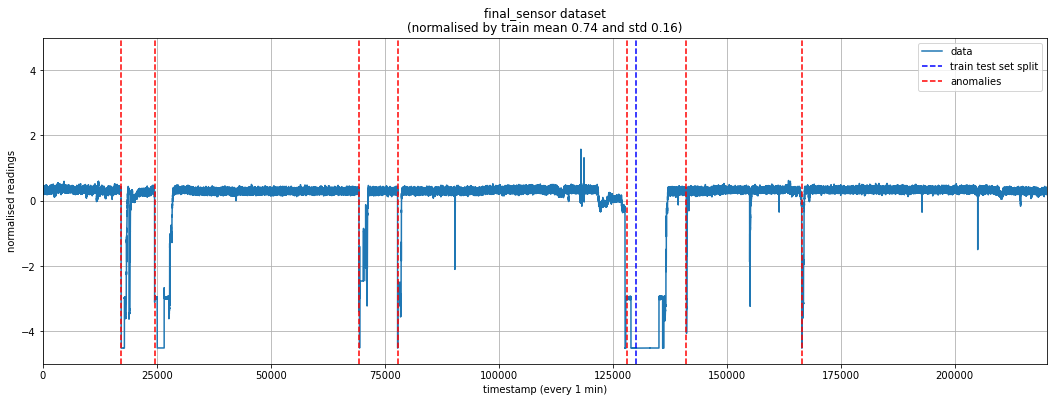

In [7]:
dataset = 'final_sensor'
idx_split = [0, 130000] # 5 anomalies

t, readings_normalised = process_and_save_specified_dataset(dataset, idx_split, save_file=True)

* t - timestamp for each reading in the time series.
* t_unit - unit for the interval between two consecutive timestamps.
* readings - the original time series values; same as the time series loaded from the original .csv file.
* idx_anomaly - indices where the anomalies occurred; computed from the anomaly timestamps from the original .csv file.
* idx_split - indices between which the training set is created. We took a section of the original time series where no anomalies have occurred as the training set.
* training - normalised time series for the training set.
* test - normalised time series for the test set.
* t_train - indices for the training set readings.
* t_test - indices for the test set readings.
* idx_anomaly_test - indices for the anomalies in the test set.